In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-12 19:14:21.844612: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 19:14:21.846671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 19:14:21.852744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731456861.863463 3375602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731456861.867182 3375602 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 19:14:21.879306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)  # Shape Z as (nrows, 1)

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # Shared scaler for Y and Z

# Fit-transform X
x = scaler_X.fit_transform(X)

# Mask and scale non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten() 

# Scale Z with the same scaler as Y
z = scaler_Y.transform(Z)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

y_tr2, y_ts2, z_tr, z_ts = train_test_split(y, z, test_size=0.2, random_state=42)
y_ts2, y_vl, z_ts, z_vl = train_test_split(y_ts2, z_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [4]:
class DNNHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        
        model.add(layers.Input(shape=(x_ncols,)))
        num_layers = hp.Int('num_layers', 2, 5)

        for i in range(num_layers):
            units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)
            model.add(layers.Dense(units, activation='relu'))

        model.add(layers.Dense(100, activation='sigmoid'))
        model.compile(optimizer='adam', loss='mse')
        
        return model

tuner = kt.RandomSearch(
    DNNHyperModel(),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='trials',
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}


W0000 00:00:1731456863.439261 3375602 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
tuner.search(
    x_tr, y_tr,
    epochs=200,
    validation_data=(x_ts, y_ts),
    batch_size=128,
    callbacks=[early_stop, lr_schedule]
)

Trial 100 Complete [00h 00m 08s]
val_loss: 0.0003280140517745167

Best val_loss So Far: 8.226760837715119e-05
Total elapsed time: 00h 17m 38s


In [ ]:
tuner.results_summary(num_trials=10)

Results summary
Results in trials/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 057 summary
Hyperparameters:
num_layers: 5
units_0: 512
units_1: 192
units_2: 192
units_3: 448
units_4: 512
Score: 8.226760837715119e-05

Trial 046 summary
Hyperparameters:
num_layers: 4
units_0: 448
units_1: 192
units_2: 512
units_3: 448
units_4: 320
Score: 8.910323958843946e-05

Trial 017 summary
Hyperparameters:
num_layers: 5
units_0: 512
units_1: 512
units_2: 128
units_3: 320
units_4: 448
Score: 9.100791794480756e-05

Trial 070 summary
Hyperparameters:
num_layers: 5
units_0: 512
units_1: 320
units_2: 512
units_3: 256
units_4: 512
Score: 9.115243301494047e-05

Trial 082 summary
Hyperparameters:
num_layers: 5
units_0: 256
units_1: 384
units_2: 448
units_3: 384
units_4: 320
Score: 9.1760084615089e-05

Trial 095 summary
Hyperparameters:
num_layers: 5
units_0: 320
units_1: 320
units_2: 320
units_3: 384
units_4: 256
Score: 9.53442431637086e-05

Trial 041 summary
Hy

In [12]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 192)            │        98,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 448)            │        86,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       229,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 508,324 (1.94 MB)

 Trainable params: 508,324 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', \
                                              min_delta=1.0e-6, patience=5)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[stop_early, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0441 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 8.8001e-04 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4219e-04 - val_loss: 5.2717e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7804e-04 - val_loss: 3.8711e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3991e-04 - val_loss: 2.8724e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7908e-04 - val_loss: 2.4594e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2661e-04 - val_loss: 2

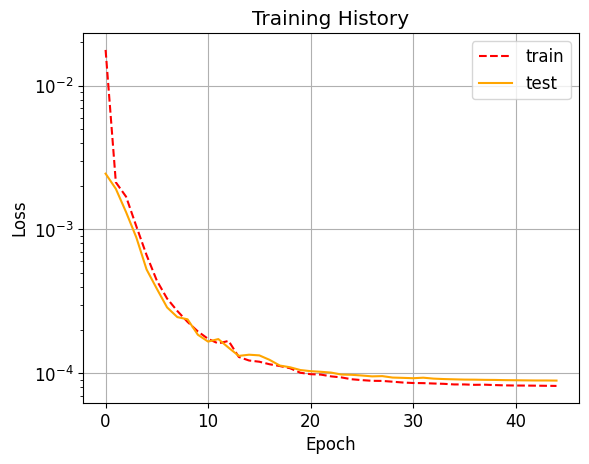

In [14]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


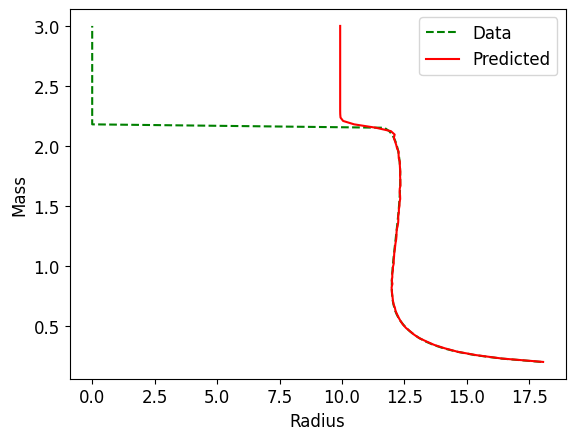

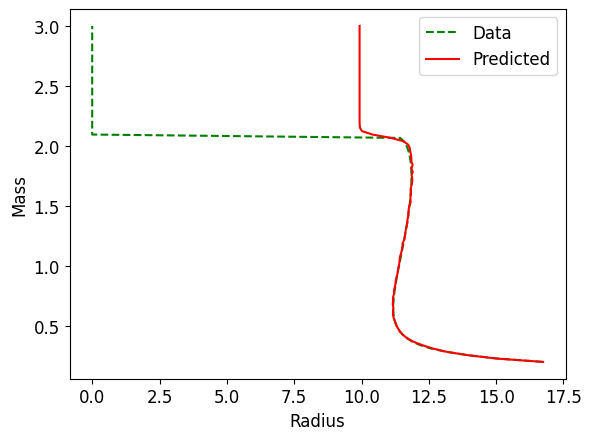

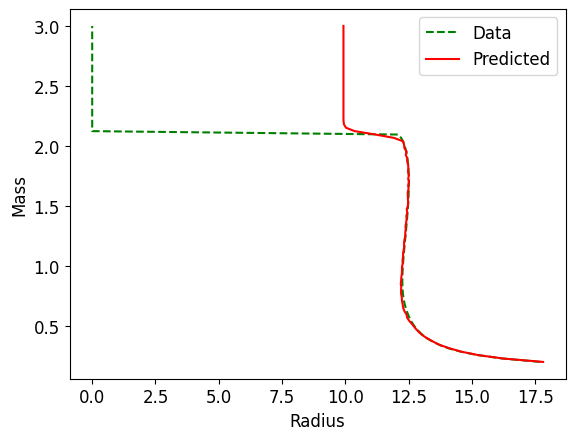

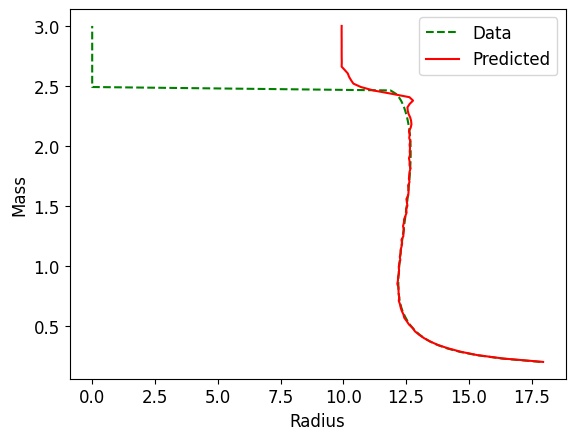

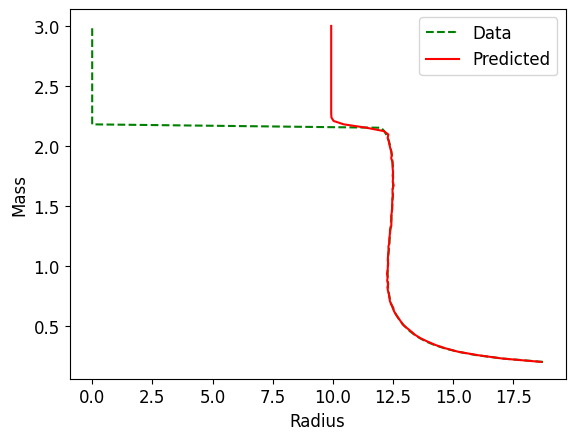

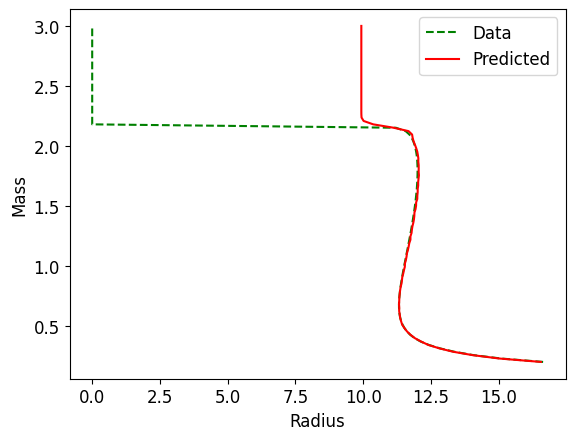

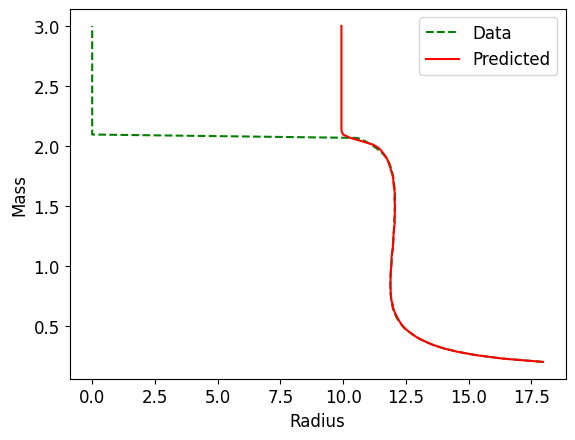

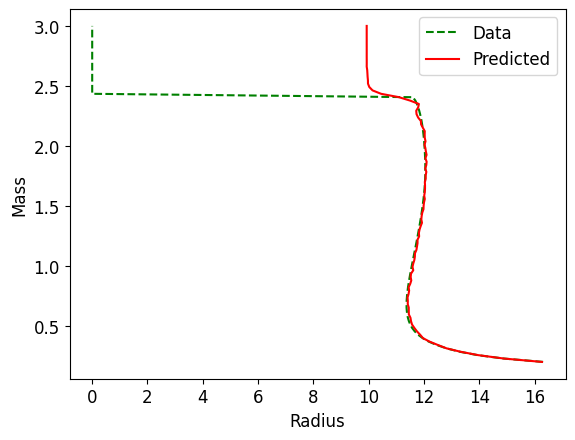

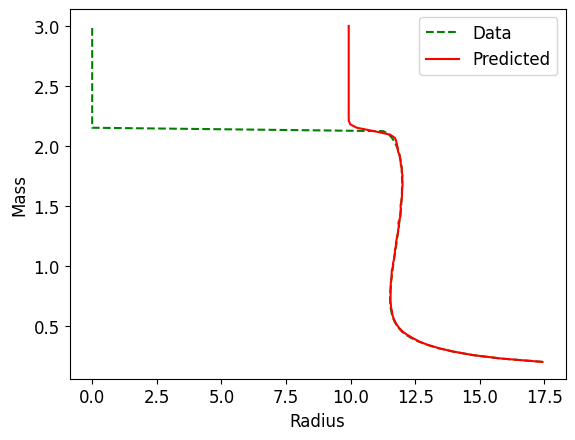

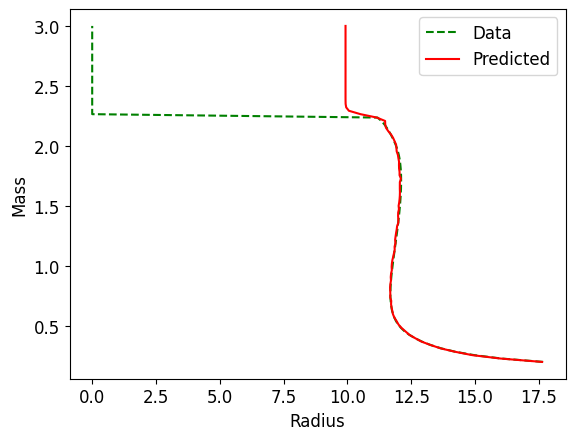

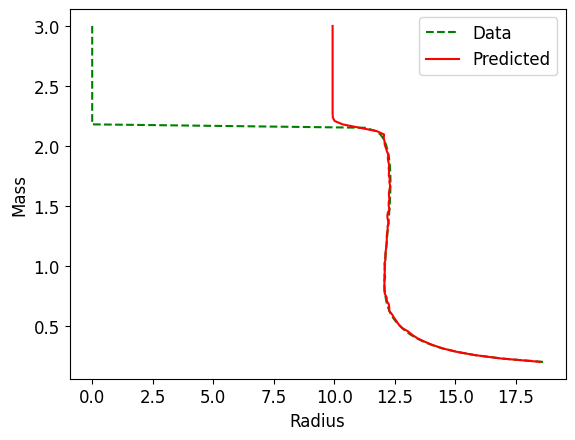

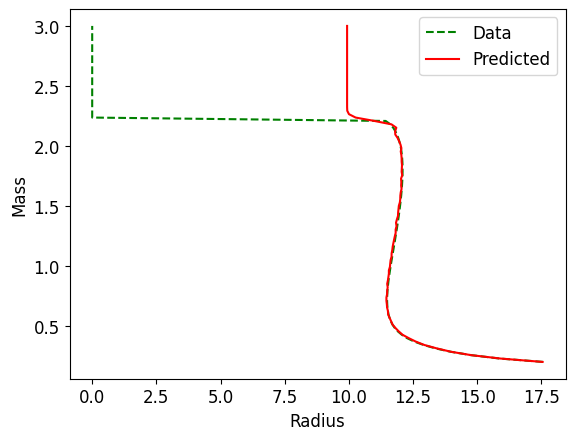

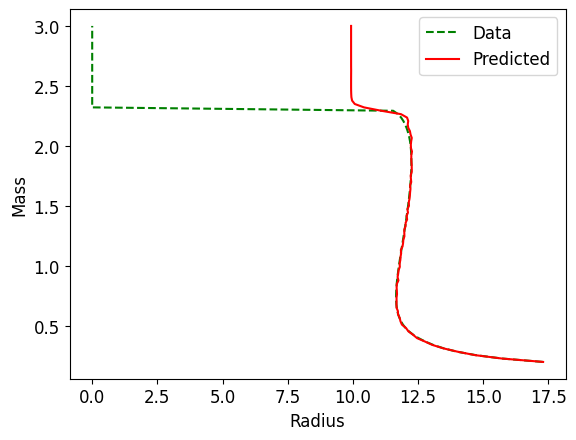

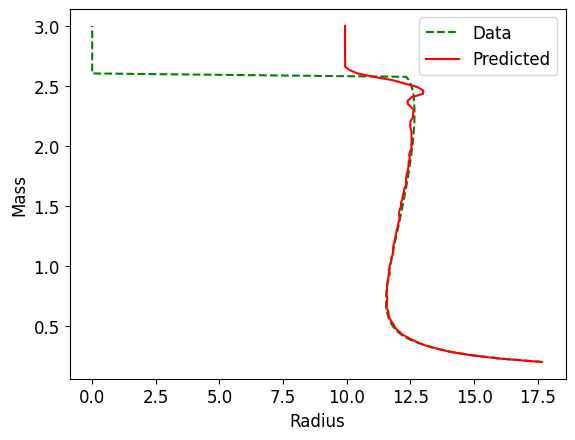

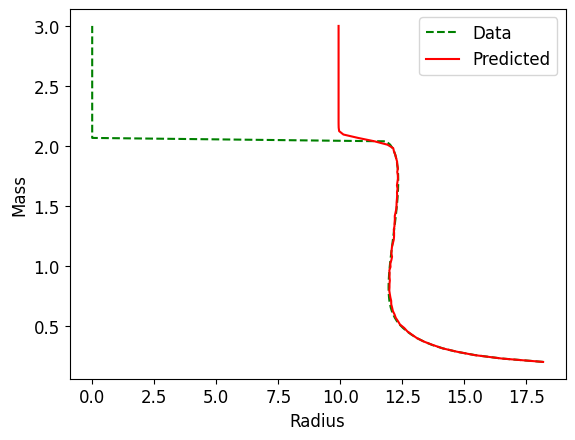

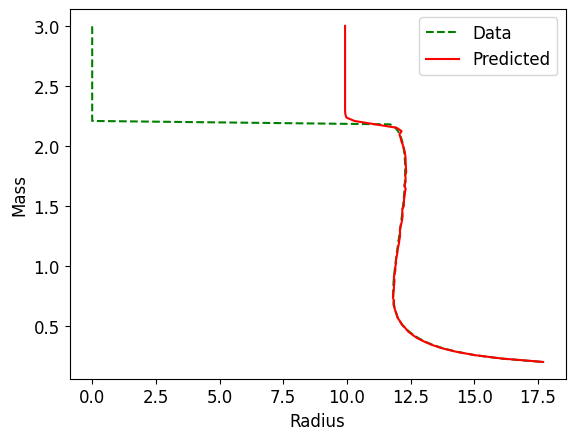

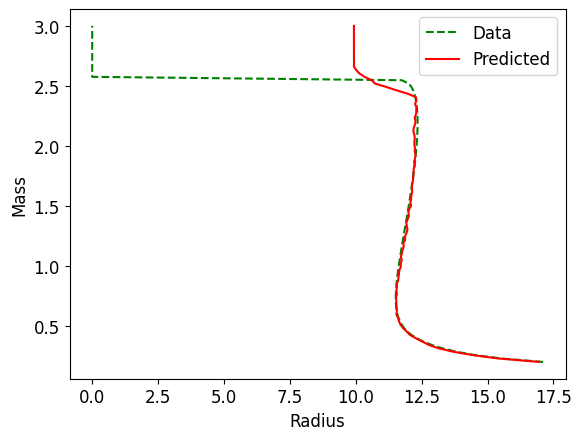

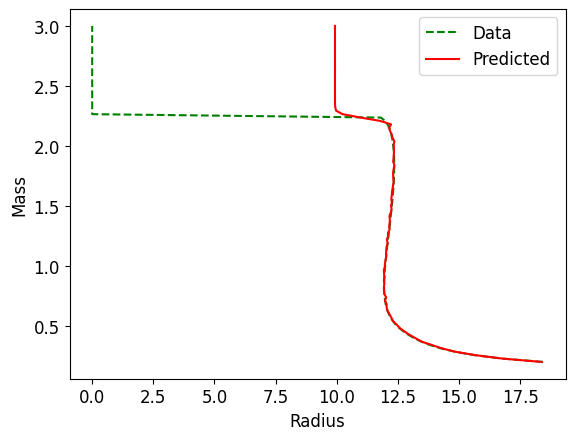

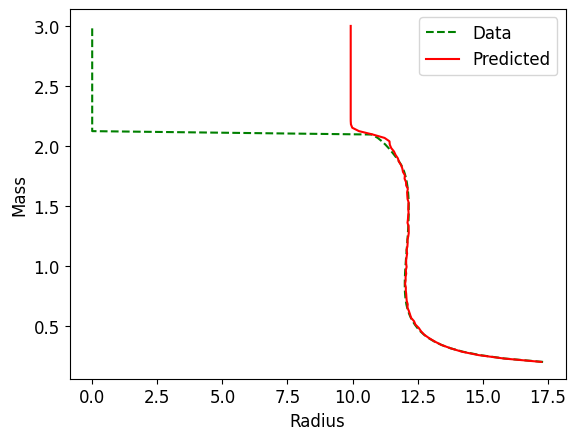

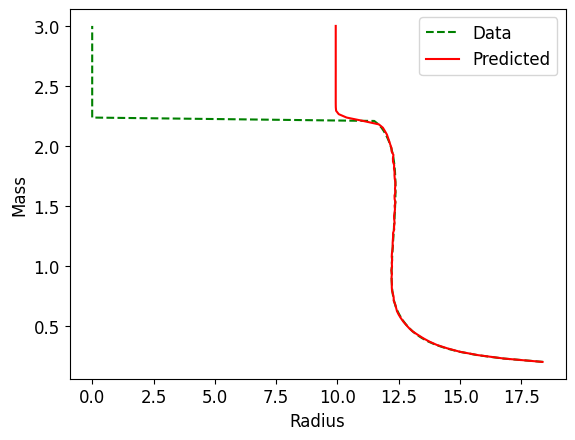

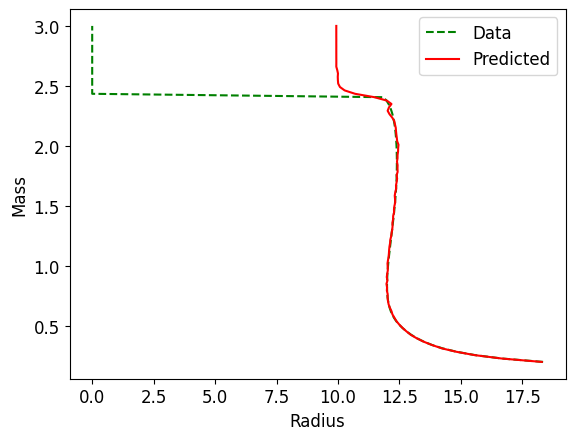

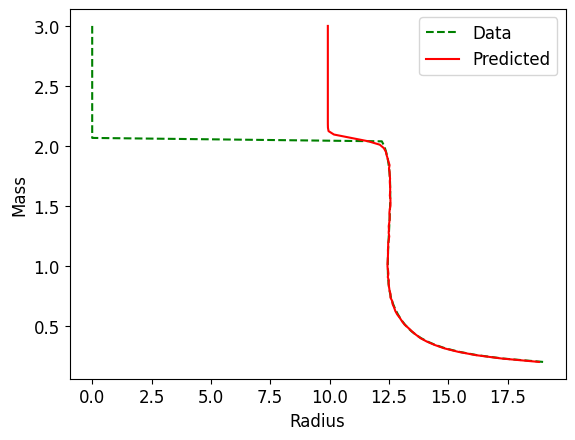

In [15]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

# Process each row individually
for i in range(y_pr.shape[0]):
    # Step 1: Identify the index of the first negative value in the row
    if np.any(y_pr[i] < 0):  # Check if there is any negative value
        i_nz = np.where(y_pr[i] < 0)[0][0]
        
        # Step 2: Set all values after the first negative value to zero
        y_pr[i, i_nz:] = 0

    # Step 3: Create a mask to identify non-zero values for denormalization
    nz_pr = y_pr[i] != 0
    nz_dt = y_vl[i] != 0

    # Step 4: Apply inverse_transform only on non-zero values
    if np.any(nz_pr):  # Check if there are any non-zero values
        Y_pr[i, nz_pr] = scaler_Y.inverse_transform(y_pr[i, nz_pr].reshape(-1, 1)).flatten()
    if np.any(nz_dt):  # Check if there are any non-zero values in the original validation data
        Y_vl[i, nz_dt] = scaler_Y.inverse_transform(y_vl[i, nz_dt].reshape(-1, 1)).flatten()

# Plot the results
m = np.linspace(0.2, 3.0, 100)
for i in range(22):
    plt.plot(Y_vl[i], m, label='Data', color='green', linestyle='--')
    plt.plot(Y_pr[i], m, label='Predicted', color='red')
    plt.xlabel("Radius")
    plt.ylabel("Mass")
    plt.legend()
    plt.show()


In [17]:
def post_process_radius(y_pr):
    for i in range(len(y_pr)):
        # Get the current predicted radius vector for the i-th sample
        radii = y_pr[i]

        # Find the last non-zero radius index
        i_max = np.min(np.nonzero(radii))

        # Step 1: Set all values after the last non-zero value to zero
        radii[i_max + 1:] = 0

        # Step 2: Linearly interpolate oscillating values between zero and last non-zero
        for j in range(i_max - 1, 0, -1):
            if radii[j] < 0 or radii[j] > radii[j + 1]:
                # Linearly interpolate between j-1 and the last valid non-zero value
                radii[j] = (radii[j-1] + radii[j+1]) / 2

        # Update the radius vector in the prediction array
        y_pr[i] = radii

    return y_pr

# Assuming y_pr is the predicted radius output from your model
y_pr = best_model.predict(x_vl)
print(y_pr[3])
y_pr2 = post_process_radius(y_pr)
print(y_pr2[3])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[8.3605075e-01 6.7075849e-01 5.6357670e-01 4.9424797e-01 4.4234982e-01
 3.9966884e-01 3.6813828e-01 3.4226790e-01 3.2219779e-01 3.0471337e-01
 2.9503220e-01 2.7992392e-01 2.7057499e-01 2.6022291e-01 2.5673893e-01
 2.4998826e-01 2.4535047e-01 2.4239552e-01 2.3748863e-01 2.3925114e-01
 2.3688699e-01 2.3636104e-01 2.3592514e-01 2.3137380e-01 2.3408048e-01
 2.3429936e-01 2.3785570e-01 2.3853654e-01 2.3737265e-01 2.3947884e-01
 2.4369872e-01 2.4174525e-01 2.4502349e-01 2.4497084e-01 2.4890411e-01
 2.5128517e-01 2.4852011e-01 2.5612420e-01 2.5708550e-01 2.5872806e-01
 2.5508115e-01 2.5867116e-01 2.5935811e-01 2.6479477e-01 2.6979446e-01
 2.6758343e-01 2.7309752e-01 2.7121153e-01 2.6917049e-01 2.7628273e-01
 2.7788076e-01 2.7747366e-01 2.7614781e-01 2.8186858e-01 2.7950171e-01
 2.8080434e-01 2.8207156e-01 2.8602269e-01 2.8204757e-01 2.8255999e-01
 2.7969658e-01 2.8398043e-01 2.8283992e-01 2.8406695e-01 2.8221688e-01
 2.8515729e-01 2.8077832e-01 2.8268808e-